# Libraries

In [1]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

import sys
import glob
import  scipy.optimize    as op
import urllib.request
from astropy.table import Table


#-- input/output functions related to DESI spectra
#import desispec.io

## Calling the catalog

In [2]:
file = "QSO_cat_fuji_sv1_dark_bal_mask_v1.0.fits"
local_dir = "/home/colgoat/Jupyter/"
local_file = os.path.join(local_dir,file)
catalog = Table.read(local_file)
f = (catalog['Z']>=2.1) & (catalog['PROGRAM']=='dark') & (catalog['HPXPIXEL']==10282)
new_cat = catalog[f]
new_cat

TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PROBA_RF,MASKBITS,SV1_DESI_TARGET,SV1_SCND_TARGET,DESI_TARGET,COADD_NUMEXP,COADD_EXPTIME,CMX_TARGET,SV2_DESI_TARGET,SV3_DESI_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,SCND_TARGET,TSNR2_LYA,TSNR2_QSO,DELTA_CHI2_MGII,A_MGII,SIGMA_MGII,B_MGII,VAR_A_MGII,VAR_SIGMA_MGII,VAR_B_MGII,Z_RR,Z_QN,C_LYA,C_CIV,C_CIII,C_MgII,C_Hbeta,C_Halpha,Z_LYA,Z_CIV,Z_CIII,Z_MgII,Z_Hbeta,Z_Halpha,QSO_MASKBITS,HPXPIXEL,SURVEY,PROGRAM,PCA_COEFFS,PCA_CHI2,BAL_PROB,BI_CIV,ERR_BI_CIV,NCIV_2000,VMIN_CIV_2000,VMAX_CIV_2000,POSMIN_CIV_2000,FMIN_CIV_2000,AI_CIV,ERR_AI_CIV,NCIV_450,VMIN_CIV_450,VMAX_CIV_450,POSMIN_CIV_450,FMIN_CIV_450,BI_SIIV,ERR_BI_SIIV,NSIIV_2000,VMIN_SIIV_2000,VMAX_SIIV_2000,POSMIN_SIIV_2000,FMIN_SIIV_2000,AI_SIIV,ERR_AI_SIIV,NSIIV_450,VMIN_SIIV_450,VMAX_SIIV_450,POSMIN_SIIV_450,FMIN_SIIV_450,BALMASK,Z_MASK,ZERR_MASK,ZWARN_MASK,CHI2_MASK,DELTACHI2_MASK,SPECTYPE_MASK,SNR_CIV
,,,,,,deg,deg,,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,,km / s,km / s,km / s,,km / s,km / s,,km / s,km / s,km / s,,km / s,km / s,,km / s,km / s,km / s,,km / s,km / s,,km / s,km / s,km / s,,,,,,,,,
int64,float64,float64,int64,bytes6,int32,float64,float64,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,int16,int64,int64,int64,int16,float32,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,bytes3,bytes4,float32[5],float32,float32,float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],float32,float32,int32,float32[5],float32[5],float32[5],float32[5],float32,float32,int32,float32[17],float32[17],float32[17],float32[17],uint8,float64,float64,int64,float64,float64,bytes6,float64
39628362695576436,2.8416229272676015,0.00032908791013198203,0,QSO,0,197.14390063990936,24.52098352105162,PSF,0.01735756,2.3939388,3.1558244,3.0474098,3.3776402,6.646939,1261.5374,438.6839,85.196915,3.6998565,0.798743,0.943547462409841,0.943547462409841,0.943547462409841,0.943547462409841,0.943547462409841,0.9813056305646897,0,54043195528495108,0,0,6,4035.6438,0,0,0,0,0,0,647.7955,169.77591,--,--,--,--,--,--,--,2.8416228,2.8446302,0.999997,0.99999416,0.9999999,7.459293e-05,1.4724725e-05,4.361528e-05,2.8442981,2.8439817,2.8446302,0.4838516,-0.094580084,0.034311153,10,10282,sv1,dark,35.26518 .. -0.19467184,1.2041646,0.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0,-1.0,-1.0,-1,-1.0,-1.0,-1,3.568163194188528
39628362691384025,2.241123990212007,0.00013619029778055847,0,GALAXY,0,196.9679519879933,24.56685640575941,PSF,0.018219369,3.9227269,5.548474,6.6379075,8.6862,11.593429,1343.1218,474.38766,106.84847,3.5014746,0.79002535,0.9408291455349964,0.9408291455349964,0.9408291455349964,0.9408291455349964,0.9408291455349964,0.9948333728313447,0,4665729213955883012,131072,0,6,4035.6438,0,0,0,0,0,0,644.00146,179.21617,4.543879,-2695.9287,7988.7046,2698.2803,-26377143000000.0,-57683927000000.0,-26377143000000.0,0.38234955,2.2411656,1.0,1.0,0.9999896,0.9999998,4.5593447e-06,3.392021e-06,2.2411656,2.240448,2.2410743,2.235775,0.7045512,-0.04391338,24,10282,sv1,dark,80.79744 .. 0.5062046,1.3529189,0.0,0.0,0.0,0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0,0

## DESI spec extraction tutorial

In [3]:
#-- get the data for all observations of this TARGETID
special_ID = new_cat["TARGETID"][3]
these_spec = new_cat[new_cat["TARGETID"]==special_ID]
these_spec

#-- get the SURVEY, PROGRAM, SPECTYPE, and redshift values for each of the five spectra of this object
survey   = new_cat["SURVEY"].data.astype(str)
program  = new_cat["PROGRAM"].data.astype(str)
redshift = np.round(new_cat["Z"].data,5)
spectype = new_cat["SPECTYPE"].data.astype(str)

print("\tSURVEY  PROGRAM  SPECTYPE  REDSHIFT")
for i in range(6):
    print("{0:1}/5\t{1:7} {2:8} {3:8} {4:8}".format(i+1, survey[i], program[i], spectype[i], redshift[i]))


	SURVEY  PROGRAM  SPECTYPE  REDSHIFT
1/5	sv1     dark     QSO       2.84162
2/5	sv1     dark     GALAXY    2.24112
3/5	sv1     dark     QSO       2.87377
4/5	sv1     dark     QSO       2.31762
5/5	sv1     dark     QSO       2.12619
6/5	sv1     dark     QSO       2.36292


In [4]:
def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where((new_cat["TARGETID"]==tid) & (new_cat["SURVEY"]==survey) & (new_cat["PROGRAM"]==program))[0][0]
    
    print(idx)
    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = new_cat["HPXPIXEL"].astype(str)

    '''if "sv" in survey:
        specprod = "fuji"

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/{specprod}"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"'''

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra("coadd-sv1-dark-10282.fits")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==new_cat["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec


In [5]:
tid = special_ID #-- TARGETID
rand_QSO1 = get_spec_data(new_cat["TARGETID"][0], survey="sv1", program="dark")
rand_QSO2 = get_spec_data(new_cat["TARGETID"][1], survey="sv1", program="dark")
rand_QSO3 = get_spec_data(new_cat["TARGETID"][2], survey="sv1", program="dark")
rand_QSO4 = get_spec_data(new_cat["TARGETID"][3], survey="sv1", program="dark")
type(rand_QSO1)

0


NameError: name 'desispec' is not defined

In [6]:
lines = {
  "Lyb": 1025.72,
  "Lya": 1215.67,
  "CIV": 1549.06,
  "CIII": 1908.734,
  "MgII": 2798.75,
  "OIII": 5006.843,
  "Ha": 6562.819,
  "OVI": 1035,
  "NV": 1240.14,
  "CII": 2326.44,
  "HeII": 1640.42,
  "SiIV": 1396.76
}

NameError: name 'rand_QSO1' is not defined

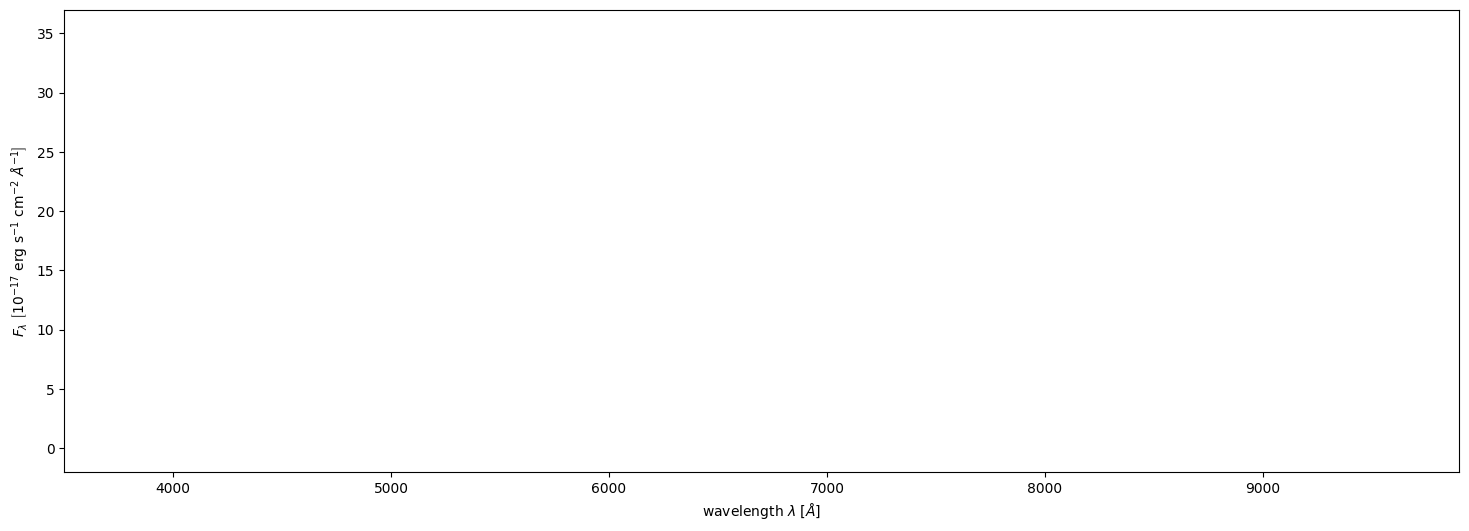

In [8]:
#-- plot the spectra
fig, ax = plt.subplots(1, 1, figsize=(18,6))
ax.set_xlim(3500, 9900)
ax.set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
ax.set_ylim(-2, 37)
ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

spectra = ( rand_QSO1, rand_QSO2, rand_QSO3, rand_QSO4  )
zwarn   = (0,0,0,0)
coaddfs = (0,0,0,0)
for PROG,ST,spec,color,zw,cfs in zip(("DARK","DARK","DARK","DARK"),("QSO","QSO","GALAXY","QSO") \
                                     ,spectra,("k","g","b","r"),zwarn,coaddfs):
    for band in ("b","r","z"):
        label = f"PROG={PROG} | SPECTYPE={ST} | COADD_FIBERSTATUS={cfs} | ZWARN={zw}" if band=="b" else ""
        ax.plot(spec.wave[band], convolve(spec.flux[band][0], Gaussian1DKernel(5)), label=label, color=color, lw=2)

        
ax.text(3600, -1, f"TARGETID = {tid}", ha="left", va="bottom")
ax.legend(markerfirst=False, fontsize=18, handletextpad=0.5, frameon=False)
plt.tight_layout()

## Target selection

In [9]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

import sys
import glob
import  scipy.optimize    as op
import urllib.request
from astropy.table import Table


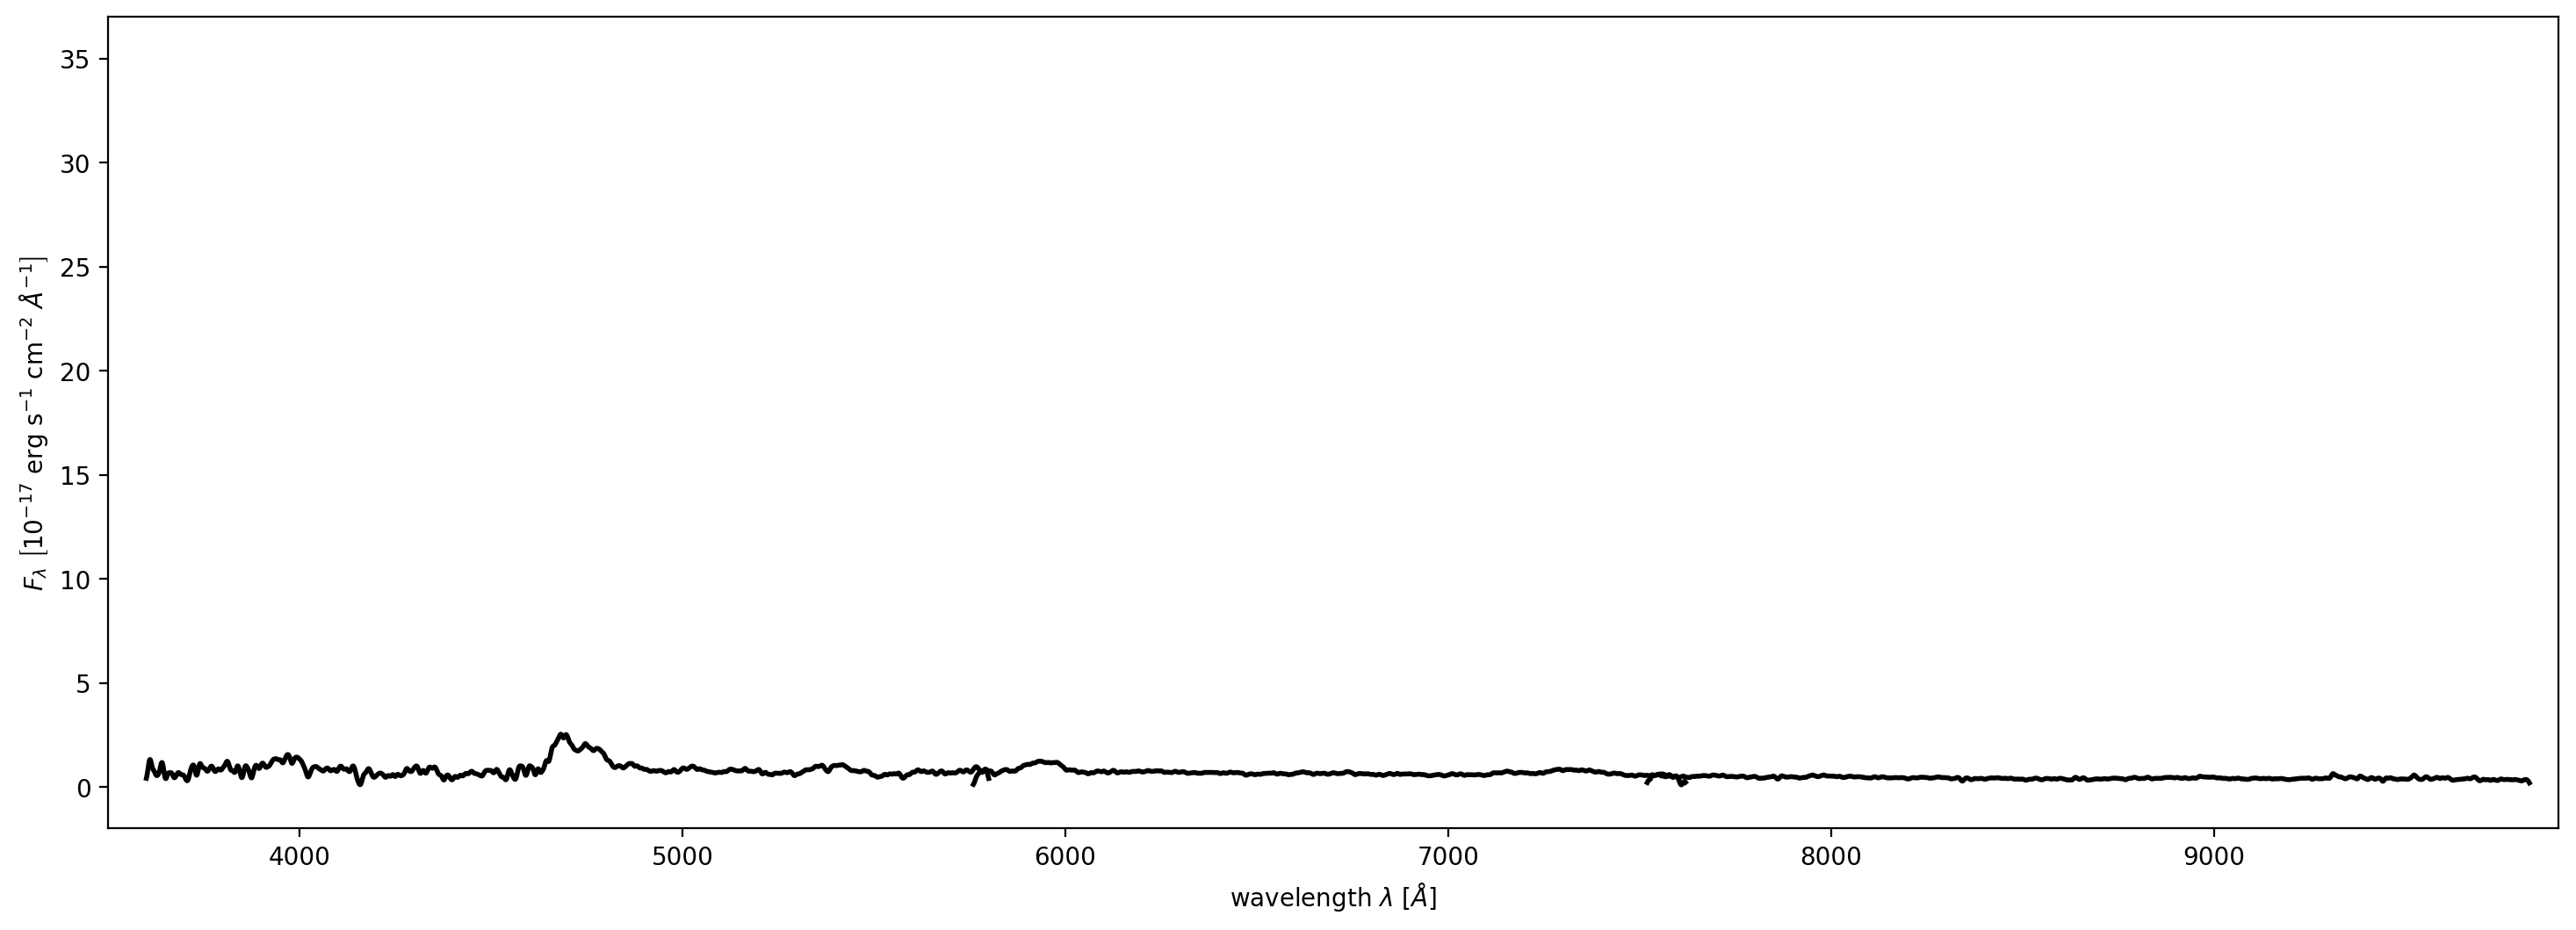

In [10]:
from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel
local_dir="/home/colgoat/Jupyter/"
file="coadd-sv1-dark-10282.fits"
archivo_local = os.path.join(local_dir,file)
hdul = fits.open(archivo_local)
b_wave = hdul[3].data
b_flux = hdul[4].data[55]
r_wave = hdul[8].data
r_flux = hdul[9].data[55]
z_wave = hdul[13].data
z_flux = hdul[14].data[55]

plt.figure(figsize=(18,6),dpi=200)

#plt.plot(b_wave,b_flux)
#plt.plot(r_wave,r_flux)
#plt.plot(z_wave,z_flux)

plt.xlim(3500, 9900)
plt.ylim(-2, 37)
plt.xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
plt.ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

plt.plot(b_wave,convolve(b_flux, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(r_wave,convolve(r_flux, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(z_wave,convolve(z_flux, Gaussian1DKernel(5)), color ='k',lw=2)

In [11]:
hdul.info()

Filename: /home/colgoat/Jupyter/coadd-sv1-dark-10282.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  FIBERMAP      1 BinTableHDU    197   113R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   678R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 113)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 113)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 113)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 113)   float32   
  8  R_WAVELENGTH    1 ImageHDU        10   (2326,)   floa

In [12]:
file_table = Table.read(archivo_local)

selected = []

for x in range(len(new_cat)):
    selected.append(new_cat["TARGETID"][x])

chosen_ini = np.array(selected)
chosen_bool = np.isin(file_table["TARGETID"],chosen_ini)
chosen_ibool = np.invert(chosen_bool)

idx = np.where(chosen_ibool)
print(len(chosen_ini),len(chosen_bool),len(idx[0]))
np.where(chosen_bool)
idx

6 113 107


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 108, 109,
        110, 111, 112]),)

In [13]:
with fits.open('/home/colgoat/Jupyter/desi_test/coadd-sv1-dark-10282.fits', mode='update') as hdul:
    
    HDUnames = ['PRIMARY','FIBERMAP','EXP_FIBERMAP', \
               "B_WAVELENGTH","B_FLUX","B_IVAR","B_MASK","B_RESOLUTION", \
               "R_WAVELENGTH","R_FLUX","R_IVAR","R_MASK","R_RESOLUTION", \
               "Z_WAVELENGTH","Z_FLUX","Z_IVAR","Z_MASK","Z_RESOLUTION", \
               "SCORES"]
    #First: BinaryTable (catalog)
    T1 = Table.read(hdul[1])
    T1.remove_rows(idx)
    hdu_f = fits.BinTableHDU(T1, name = HDUnames[0]) #First hdu
    hdul[1] = hdu_f
    
    #Image HDU arrays (spectra) 12 (4-7,9-12,14-17)
    
    for i in range(15):
        c = i+3 #counter
        #print(c)
        if ((c != 3) and (c != 8) and (c != 13)):
                    hdu_temp = hdul[c].data
                    hdu_temp = np.delete(hdu_temp,np.invert(chosen_bool),0)
                    hdu_ff = fits.ImageHDU(hdu_temp,name = HDUnames[c]) #hdu for file
                    hdul[c] = hdu_ff
                    
    #Last: BinaryTable (scores)
    T2 = Table.read(hdul[18])
    T2.remove_rows(idx)
    hdu_l = fits.BinTableHDU(T2, name = HDUnames[18]) #Last hdu
    hdul[18] = hdu_l
    
    hdul.flush()
    print("Done")

    
    
#d = hdul[4].data
#d = np.delete(d,np.invert(chosen_bool),0)
#hdu1 = fits.ImageHDU(d,name = "B_FLUX")
#hdul[4] = hdu1

IndexError: index 6 is out of bounds for axis 0 with size 6

In [14]:
hdul_new = fits.open('/home/colgoat/Jupyter/desi_test/coadd-sv1-dark-10282.fits')
hdul_new.info()

Filename: /home/colgoat/Jupyter/desi_test/coadd-sv1-dark-10282.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  PRIMARY       1 BinTableHDU    219   6R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   678R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU         8   (2751, 6)   float32   
  5  B_IVAR        1 ImageHDU         8   (2751, 6)   float32   
  6  B_MASK        1 ImageHDU        10   (2751, 6)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU         9   (2751, 11, 6)   float32   
  8  R_WAVELENGTH    1 ImageHDU        10   (2326,)   floa

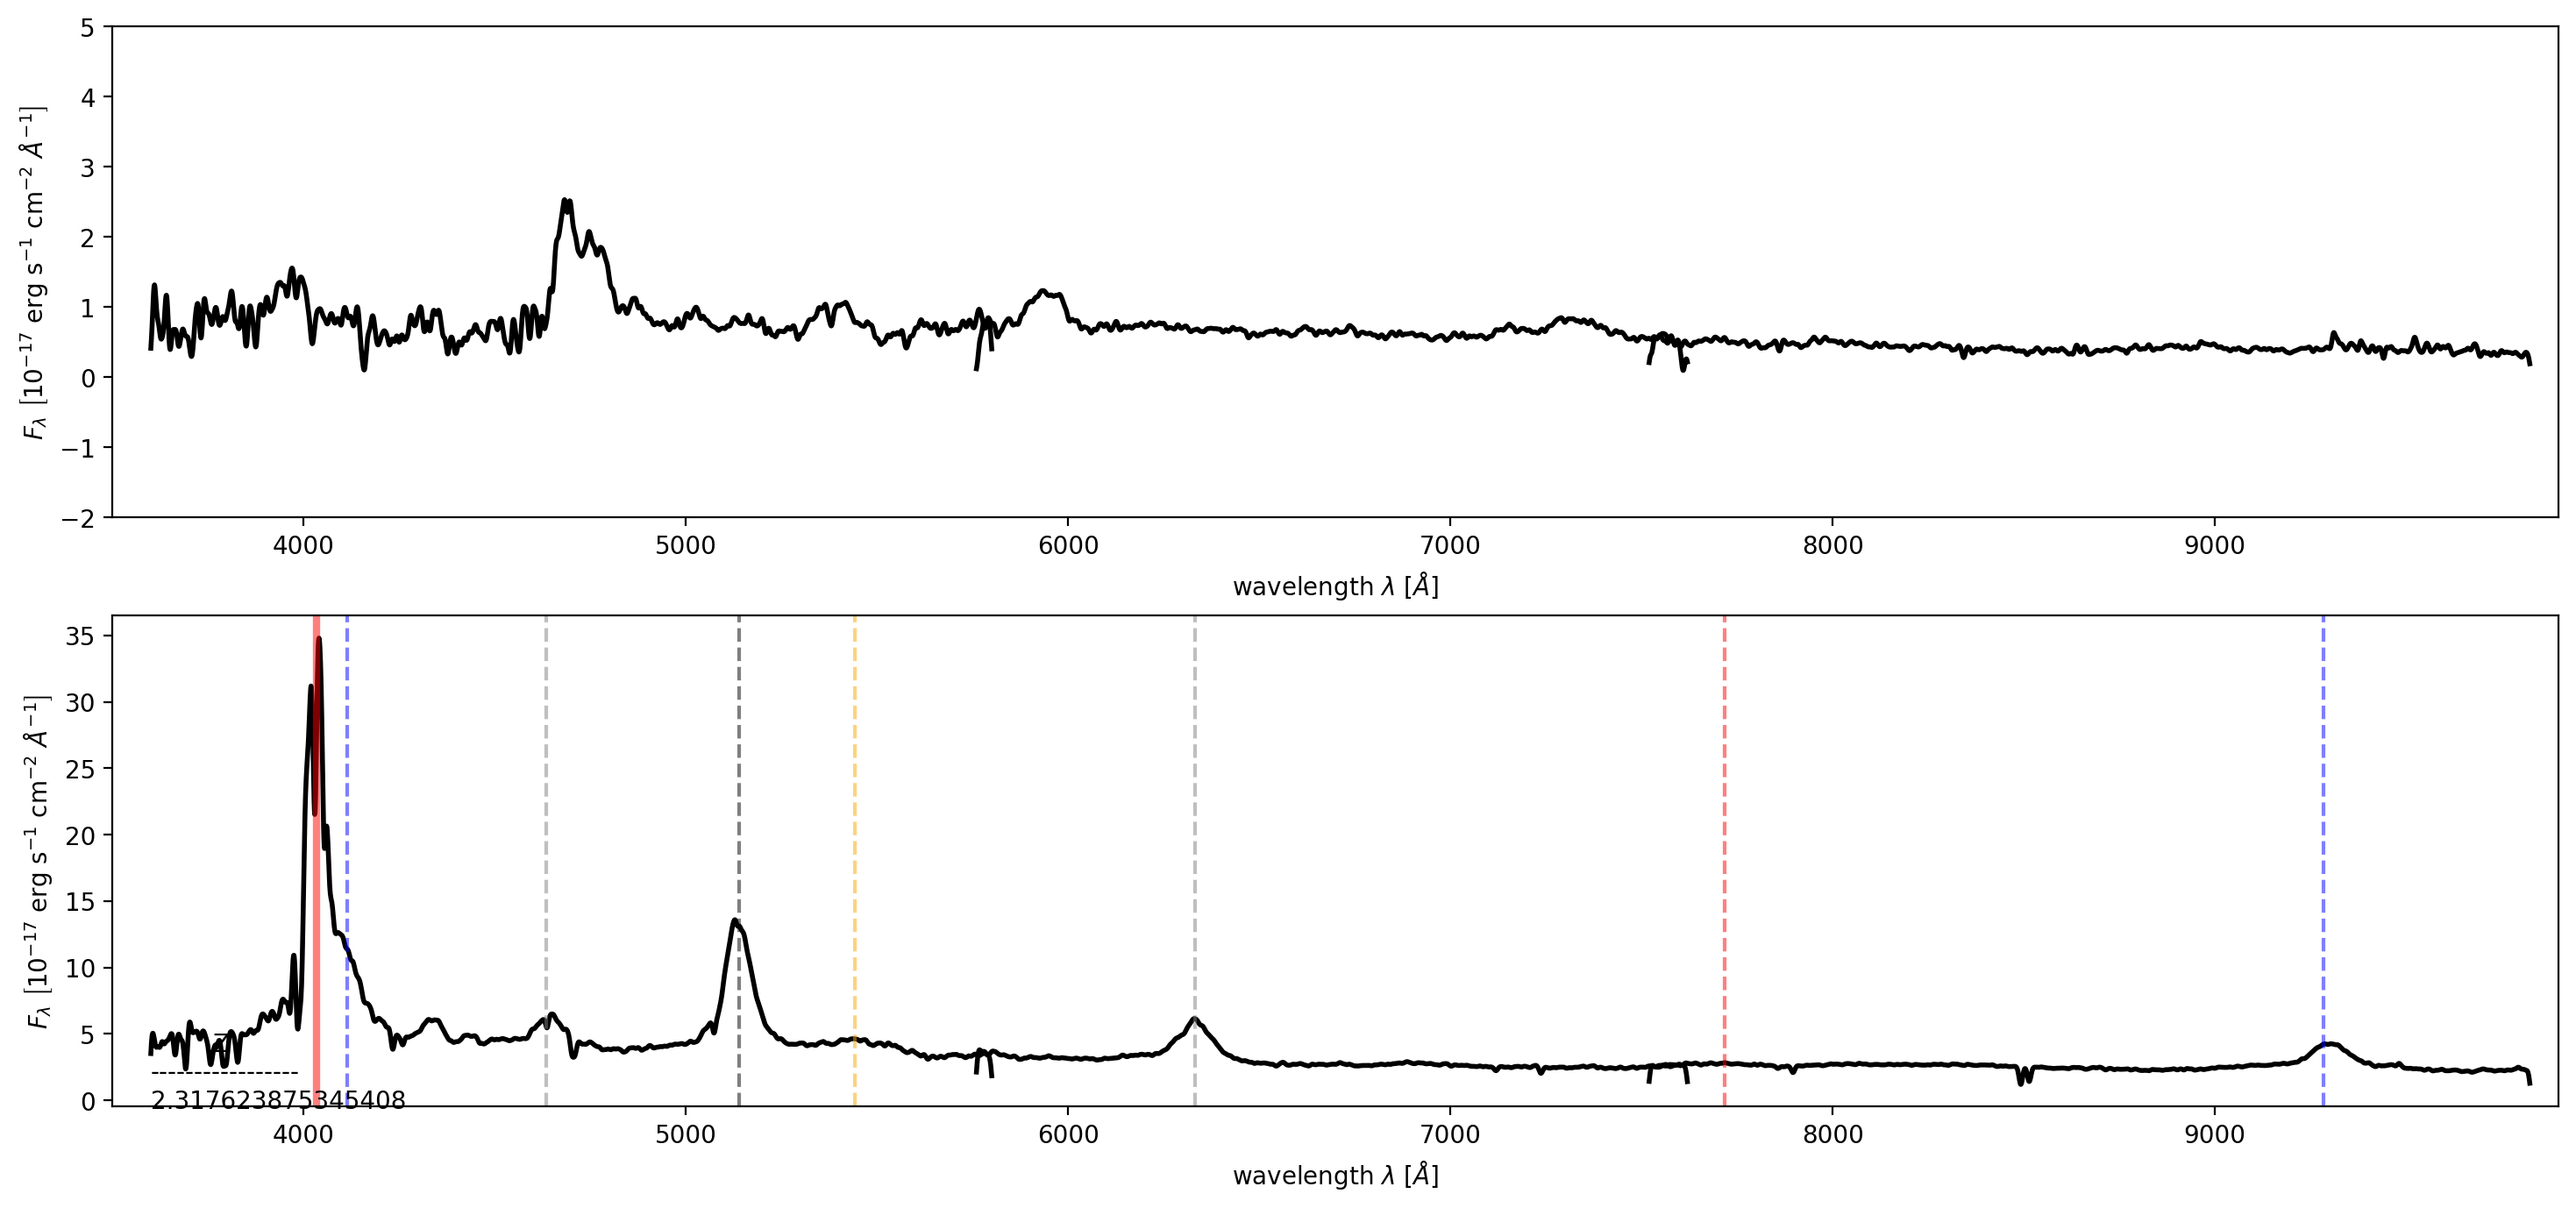

In [16]:
from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel

def ident(i):
    file = fits.open("/home/colgoat/Jupyter/desi_test/coadd-sv1-dark-10282.fits")
    cat = fits.open("QSO_cat_fuji_sv1_dark_bal_mask_v1.0.fits")
    comp = Table.read(cat)
    obj = Table.read(file)
    w = comp["TARGETID"]==obj["TARGETID"][i]
    n = comp[w]
    ti = n['Z']
    return ti


local_dir="/home/colgoat/Jupyter/"
file="coadd-sv1-dark-10282.fits"
archivo_local = os.path.join(local_dir,file)
hdul = fits.open(archivo_local)
n = [55,3]
b_wave = hdul[3].data
b_flux = hdul[4].data[n[0]]
r_wave = hdul[8].data
r_flux = hdul[9].data[n[0]]
z_wave = hdul[13].data
z_flux = hdul[14].data[n[0]]


b_wave_n = hdul_new[3].data
b_flux_n = hdul_new[4].data[n[1]]
r_wave_n = hdul_new[8].data
r_flux_n = hdul_new[9].data[n[1]]
z_wave_n = hdul_new[13].data
z_flux_n = hdul_new[14].data[n[1]]



plt.figure(figsize=(18,8),dpi=200)

plt.subplot(2, 1, 1)

plt.xlim(3500, 9900)
plt.ylim(-2, 5)
plt.xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
plt.ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")
plt.plot(b_wave,convolve(b_flux, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(r_wave,convolve(r_flux, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(z_wave,convolve(z_flux, Gaussian1DKernel(5)), color ='k',lw=2)

plt.subplot(2, 1, 2)
plt.xlim(3500, 9900)
#plt.ylim(-2, 5)
plt.xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
plt.ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")
plt.plot(b_wave_n,convolve(b_flux_n, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(r_wave_n,convolve(r_flux_n, Gaussian1DKernel(5)), color ='k',lw=2)
plt.plot(z_wave_n,convolve(z_flux_n, Gaussian1DKernel(5)), color ='k',lw=2)
plt.text(3600, -1, f"{ident(n[1])}", ha="left", va="bottom")
plt.axvline((1+ ident(n[1])) * lines["Lya"], c='red', alpha=0.5, linewidth = 3)
plt.axvline((1+ ident(n[1])) * lines["Lyb"], c='green', alpha=0.5, linewidth = 3)
plt.axvline((1+ ident(n[1])) * lines["CIV"], c='black', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["CIII"], c='gray', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["MgII"], c='blue', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["OIII"], c='gray', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["Ha"], c='blue', alpha=0.5,ls ="-", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["OVI"], c='green', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["NV"], c='blue', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["CII"], c='red', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["HeII"], c='orange', alpha=0.5,ls ="--", linewidth = 1.5)
plt.axvline((1+ ident(n[1])) * lines["SiIV"], c='gray', alpha=0.5,ls ="--", linewidth = 1.5)